# Combine the different GMST datasets into one file

## Import libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import glob

In [3]:
inpath = "/Users/quraus001/Documents/Uni/Thesis/data/GMST/"
files = glob.glob(inpath + "*.txt")

## Load original datasets into pandas data frame

In [16]:
# Load original datasets into pandas data frame

# Load Berkeley Earth data
df = pd.read_csv(inpath + "berkeley-earth-annual-temperature.txt", comment="%", sep='\s+', skipinitialspace=True, names=["Year", "Annual Anomaly", "Annual Unc.", "Five-year Anomaly", "Five-year Unc.", "Annual Anomaly ocean under ice", "Annual Unc. ocean under ice", "Five-year Anomaly ocean under ice", "Five-year Unc. ocean under ice"])
df = df.set_index('Year')
df = df.rename(columns={"Annual Anomaly": "BerkeleyEarth"})
DF = df[["BerkeleyEarth"]].copy() # Create a new DataFrame for all datasets

# Load GISSTEMPv4 data
df = pd.read_csv(inpath + "GISSTEMPv4-temperature.txt", comment="%")
# convert all * to NaN
df = df.replace('***', np.nan)

df = df.apply(pd.to_numeric)
df = df.set_index('Year')
DF["GISSTEMPv4"] = df["J-D"] # Add to main DataFrame

# Load NOAA Global Temperature data
df = pd.read_csv(inpath + "noaa-globaltemp-temperature.txt", comment="%", sep='\s+', skipinitialspace=True, names=["Year", "Annual Anomaly", "?1", "?2", "?3", "?4"])
df = df.set_index('Year')
df = df.rename(columns={"Annual Anomaly": "NOAA"})
DF["NOAA"] = df["NOAA"] # Add to main DataFrame

# Load HadCRUT4 data
df = pd.read_csv(inpath + "HadCRUT4-temperature.txt", comment="%", sep=',', skipinitialspace=True)
df = df.rename(columns={"Anomaly (deg C)": "hadcrut4", "Time": "Year"})
df = df.set_index('Year')
df = df[["hadcrut4"]].copy()
DF["HadCRUT4"] = df["hadcrut4"]  # Add to main DataFrame

# Load Kadow et al. 2025 data
ds = xr.open_dataset(inpath + "Kadow_et_al_2025_AI-Infilled_HadCRUT.5.0.2.0.anomalies.ensemble_global_annual_mean_185001-202412.nc").squeeze()
ds = ds.rename({"time": "Year"})
ds = ds.drop_vars(["lat", "lon"])
df = ds.tas_mean.to_dataframe()
df.index = df.index.year
df = df.rename(columns={"tas_mean": "Kadow"})

DF["Kadow"] = df["Kadow"]  # Add to main DataFrame

DF


,BerkeleyEarth,GISSTEMPv4,NOAA,HadCRUT4,Kadow
Year,,,,,
1850,-0.436,NaN,-0.496959,-0.417711,-0.460125
1851,-0.321,NaN,-0.390814,-0.233350,-0.439743
1852,-0.292,NaN,-0.352384,-0.229399,-0.337969
1853,-0.295,NaN,-0.407147,-0.270354,-0.394087
1854,-0.283,NaN,-0.367742,-0.291521,-0.403480
...,...,...,...,...,...
2020,1.049,1.01,0.711575,0.922921,0.903198
2021,0.895,0.85,0.559328,0.761906,0.739998
2022,0.936,0.89,0.591291,0.801305,0.793923


## Rebase all datasets to the same reference period

In [22]:
ref_period = (1951, 1980)

df = DF.copy()

# Select reference years
ref_df = df[(df.index >= ref_period[0]) & (df.index <= ref_period[1])]

# Calculate each dataset's mean over 1951–1980
ref_means = ref_df[['GISSTEMPv4', 'BerkeleyEarth', 'NOAA', 'HadCRUT4', 'Kadow']].mean()

# Subtract each dataset's own mean to rebase anomalies to 1951–1980
df['GISSTEMPv4_rebased']   = df['GISSTEMPv4']   - ref_means['GISSTEMPv4']
df['BerkeleyEarth_rebased'] = df['BerkeleyEarth'] - ref_means['BerkeleyEarth']
df['NOAA_rebased']         = df['NOAA']         - ref_means['NOAA']
df['HadCRUT4_rebased']     = df['HadCRUT4']     - ref_means['HadCRUT4']
df['Kadow_rebased']        = df['Kadow']        - ref_means['Kadow']

# save to csv
#outfile = '/Users/quraus001/Documents/Uni/Thesis/data/GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkleyEarth-NOAA-HadCRUT4.csv'
#df.to_csv(outfile, header=['GISSTEMPv4', 'BerkeleyEarth', 'NOAA', 'HadCRUT4', 'Kadow', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased'], index=True)

## Plot all datasets

<Axes: xlabel='Year'>

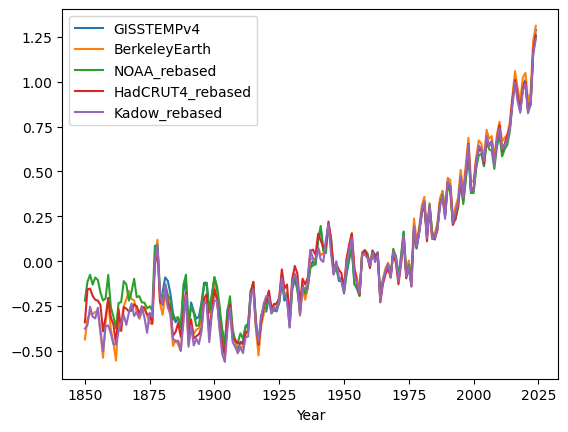

In [26]:
# plot all rebased datasets
df[['GISSTEMPv4', 'BerkeleyEarth', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']].plot()


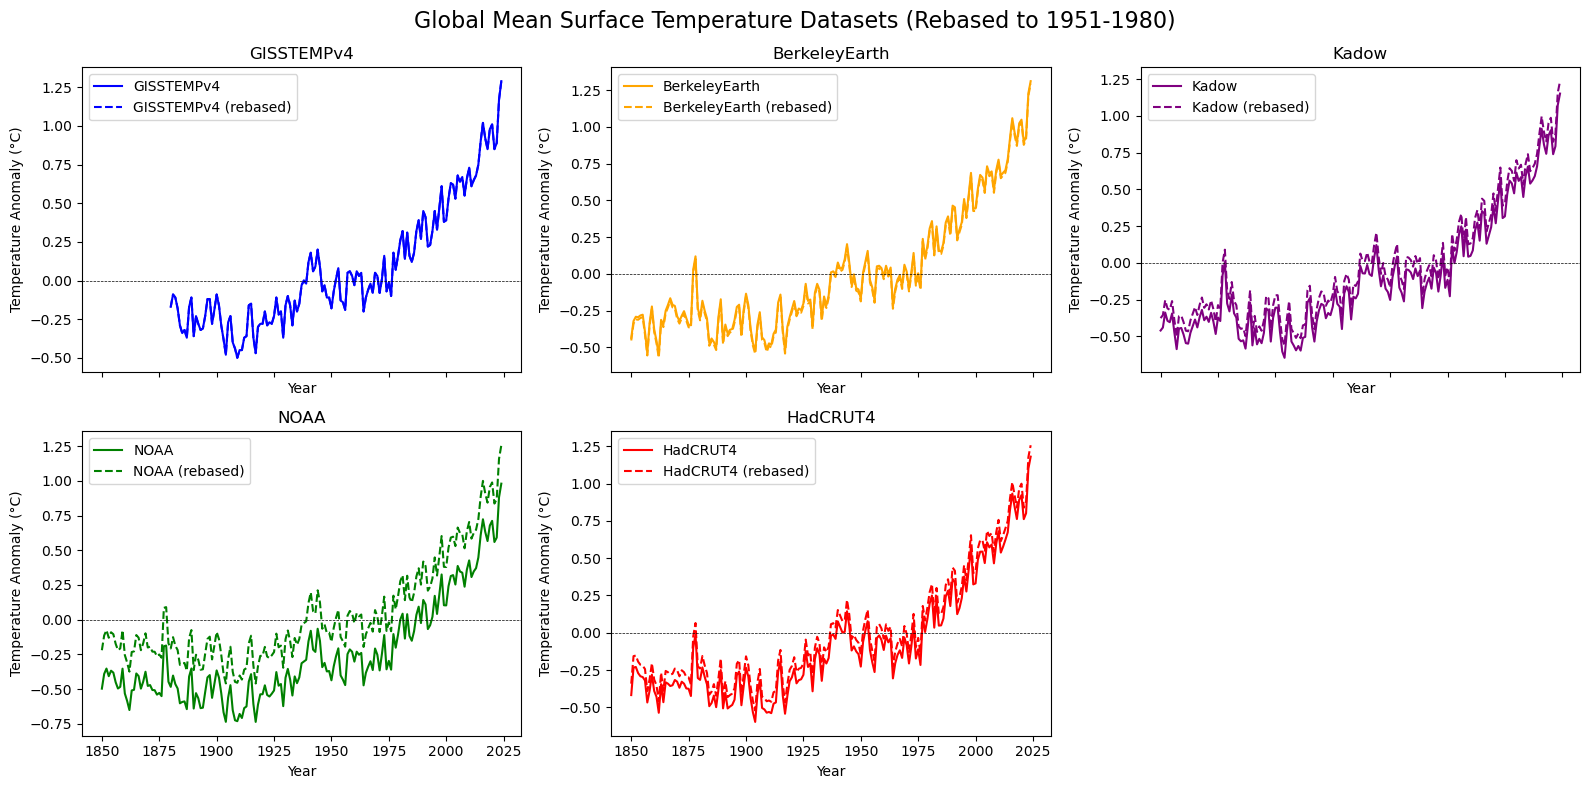

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True)

# Define plot configs: (row, col, dataset, color, title)
plot_configs = [
    (0, 0, 'GISSTEMPv4', 'blue', 'GISSTEMPv4'),
    (0, 1, 'BerkeleyEarth', 'orange', 'BerkeleyEarth'),
    (1, 0, 'NOAA', 'green', 'NOAA'),
    (1, 1, 'HadCRUT4', 'red', 'HadCRUT4'),
    (0, 2, 'Kadow', 'purple', 'Kadow'),
]

for row, col, name, color, title in plot_configs:
    ax = axes[row, col]
    ax.plot(df.index, df[name], label=name, color=color)
    rebased = f"{name}_rebased"
    if rebased in df.columns:
        ax.plot(df.index, df[rebased], label=f"{name} (rebased)", color=color, linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature Anomaly (°C)')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.legend()

# hide the empty subplot
axes[1, 2].set_visible(False)
    
fig.suptitle('Global Mean Surface Temperature Datasets (Rebased to 1951-1980)', fontsize=16)

plt.tight_layout()



## Save combined dataset

### Save to csv

In [57]:
outfile = '/Users/quraus001/Documents/Uni/Thesis/data/GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkeleyEarth-NOAA-HadCRUT4-Kadow.csv'


# write to csv with custom header
# add description of reference period, datasets, and how they were rebased
with open(outfile, 'w') as f:
    f.write("# Reference period: 1951-1980\n")
    f.write("# Datasets: GISSTEMPv4, BerkeleyEarth, NOAA, HadCRUT4, Kadow et al. 2025\n")
    f.write("# Rebased NOAA and HadCRUT4 to 1951-1980 mean\n")
    f.write("# GISSTEMPv4: Global Historical Climatology Network (GHCN)\n")
    f.write("# downloaded from https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv on 02.05.2025\n")
    f.write("# BerkeleyEarth: Berkeley Earth Surface Temperature\n")
    f.write("# downloaded from https://doi.org/10.5194/essd-12-3469-2020 on 02.05.2025\n")
    f.write("# NOAA GlobalTemp: \n")
    f.write("# downloaded from https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp on 02.05.2025\n")
    f.write("# HadCRUT4: Hadley Centre/Climatic Research Unit temperature dataset\n")
    f.write("# downloaded from https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html on 02.05.2025\n")
    f.write("# Kadow et al. 2025: AI-infilled HadCRUT4\n")
    f.write("# downloaded from https://doi.org/10.5281/zenodo.15622091 on 05.08.2025\n")
    f.write("# Year, GISSTEMPv4, BerkeleyEarth, NOAA, HadCRUT4, Kadow, NOAA_rebased, HadCRUT4_rebased, Kadow_rebased\n")

# Save all but BerkeleyEarth_rebased and GISSTEMPv4_rebased
df_saving = df[['GISSTEMPv4', 'BerkeleyEarth', 'NOAA', 'HadCRUT4', 'Kadow', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']]
df_saving.to_csv(outfile, mode='a', header=False, index=True, index_label='Year')


In [49]:
df_saving

,GISSTEMPv4,BerkeleyEarth,NOAA,HadCRUT4,Kadow,NOAA_rebased,HadCRUT4_rebased,Kadow_rebased
Year,,,,,,,,
1850,NaN,-0.436,-0.496959,-0.417711,-0.460125,-0.220257,-0.341109,-0.375673
1851,NaN,-0.321,-0.390814,-0.233350,-0.439743,-0.114113,-0.156747,-0.355290
1852,NaN,-0.292,-0.352384,-0.229399,-0.337969,-0.075682,-0.152797,-0.253516
1853,NaN,-0.295,-0.407147,-0.270354,-0.394087,-0.130445,-0.193752,-0.309635
1854,NaN,-0.283,-0.367742,-0.291521,-0.403480,-0.091041,-0.214919,-0.319028
...,...,...,...,...,...,...,...,...
2020,1.01,1.049,0.711575,0.922921,0.903198,0.988277,0.999523,0.987651
2021,0.85,0.895,0.559328,0.761906,0.739998,0.836029,0.838508,0.824451
2022,0.89,0.936,0.591291,0.801305,0.793923,0.867992,0.877908,0.878376


### Save to NetCDF


In [47]:
outfile_nc = '/Users/quraus001/Documents/Uni/Thesis/data/GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkeleyEarth-NOAA-HadCRUT4-Kadow.nc'


df_saving = df[['GISSTEMPv4', 'BerkeleyEarth', 'NOAA', 'HadCRUT4', 'Kadow', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']]
# Convert DataFrame to xarray Dataset
ds_saving = df_saving.to_xarray()

# add global attributes
ds_saving.attrs['description'] = 'Global Mean Surface Temperature datasets'
ds_saving.attrs['reference_period'] = '1951-1980'
ds_saving.attrs['datasets'] = 'GISSTEMPv4, BerkeleyEarth, NOAA, HadCRUT4, Kadow'
ds_saving.attrs['rebased'] = 'NOAA_rebased, HadCRUT4_rebased, Kadow_rebased'

# add dataset-specific attributes
# Add description, units, source, information on rebasing
ds_saving['GISSTEMPv4'].attrs = {
    'description': 'GISSTEMPv4 Global Historical Climatology Network (GHCN) dataset',
    'units': '°C',
    'source': 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv',
    'rebased': 'No rebasing applied',
    'reference_period': '1951-1980'
}
ds_saving['BerkeleyEarth'].attrs = {
    'description': 'Berkeley Earth Surface Temperature dataset',
    'units': '°C',
    'source': 'https://doi.org/10.5194/essd-12-3469-2020',
    'rebased': 'No rebasing applied',
    'reference_period': '1951-1980'
}
ds_saving['NOAA'].attrs = {
    'description': 'NOAA Global Temperature dataset',
    'units': '°C',
    'source': 'https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp',
    'rebased': 'No rebasing applied',
    'reference_period': '1971–2000'
}
ds_saving['HadCRUT4'].attrs = {
    'description': 'Hadley Centre/Climatic Research Unit temperature dataset',
    'units': '°C',
    'source': 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.1.0.annual.nc',
    'rebased': 'No rebasing applied',
    'reference_period': '1961-1990'
}   
ds_saving['Kadow'].attrs = {
    'description': 'AI-infilled HadCRUT4 dataset by Kadow et al. 2025',
    'units': '°C',
    'source': 'https://doi.org/10.5281/zenodo.15622091',
    'rebased': 'No rebasing applied',
    'reference_period': '1961-1990'
}
ds_saving['NOAA_rebased'].attrs = {
    'description': 'NOAA Global Temperature dataset rebased to 1951-1980 mean',
    'units': '°C',
    'source': 'https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp',
    'rebased': 'Rebased to 1951-1980 mean',
    'reference_period': '1951-1980'
}
ds_saving['HadCRUT4_rebased'].attrs = {
    'description': 'Hadley Centre/Climatic Research Unit temperature dataset rebased to 1951-1980 mean',
    'units': '°C',
    'source': 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.1.0.annual.nc',
    'rebased': 'Rebased to 1951-1980 mean',
    'reference_period': '1951-1980'
}

ds_saving['Kadow_rebased'].attrs = {
    'description': 'AI-infilled HadCRUT4 dataset by Kadow et al. 2025 rebased to 1951-1980 mean',
    'units': '°C',
    'source': 'https://doi.org/10.5281/zenodo.15622091',
    'rebased': 'Rebased to 1951-1980 mean',
    'reference_period': '1951-1980'
}

ds_saving.to_netcdf(outfile_nc)
ds_saving

<xarray.Dataset> Size: 11kB
Dimensions:           (Year: 175)
Coordinates:
  * Year              (Year) int64 1kB 1850 1851 1852 1853 ... 2022 2023 2024
Data variables:
    GISSTEMPv4        (Year) float64 1kB nan nan nan nan ... 0.85 0.89 1.17 1.29
    BerkeleyEarth     (Year) float64 1kB -0.436 -0.321 -0.292 ... 1.229 1.311
    NOAA              (Year) float64 1kB -0.497 -0.3908 ... 0.8813 0.9795
    HadCRUT4          (Year) float64 1kB -0.4177 -0.2333 -0.2294 ... 1.1 1.181
    Kadow             (Year) float32 700B -0.4601 -0.4397 -0.338 ... 1.073 1.153
    NOAA_rebased      (Year) float64 1kB -0.2203 -0.1141 ... 1.158 1.256
    HadCRUT4_rebased  (Year) float64 1kB -0.3411 -0.1567 -0.1528 ... 1.177 1.257
    Kadow_rebased     (Year) float32 700B -0.3757 -0.3553 ... 1.157 1.237
Attributes:
    description:       Global Mean Surface Temperature datasets
    reference_period:  1951-1980
    datasets:          GISSTEMPv4, BerkeleyEarth, NOAA, HadCRUT4, Kadow
    rebased:           NOAA_rebased, HadCRUT4_rebased, Kadow_rebased